In [1]:
%matplotlib notebook
import numpy as np
import scipy
import matplotlib.pyplot as plt
%pwd

'/mnt/c/Users/mtr22/code/ME2063/hw9'

In [2]:
# helper functions
def print_arrays(**kwargs):
    for k, v in kwargs.items():
        print(f'{k} ∈ {v.dtype}^{v.shape}')

In [3]:
# load the data
data = scipy.io.loadmat('Data-HW9.mat')
V = data['V']
t = data['t']
x = data['x']
print_arrays(x=x, t=t, V=V)

x ∈ float64^(501, 1)
t ∈ float64^(1, 401)
V ∈ float64^(501, 401)


<IPython.core.display.Javascript object>


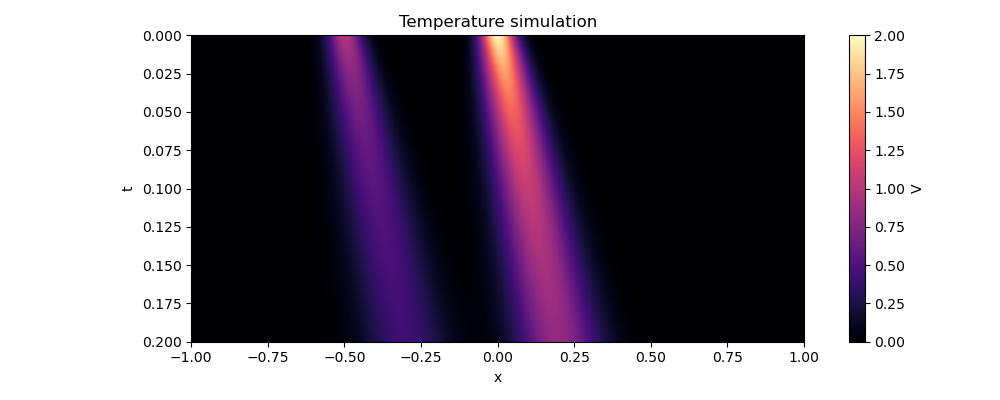

In [4]:
# plot the temperature simulation
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(V.T, extent=[x.min(), x.max(), t.max(), t.min()], aspect=5, cmap='magma')
ax.set_ylabel('t')
ax.set_xlabel('x')
ax.set_title('Temperature simulation')
plt.colorbar(im, label='V', ax=ax)
fig.tight_layout()

In [5]:
# singular value decomposition
U, S, Y = np.linalg.svd(V)
print_arrays(U=U, S=S, Y=Y)

U ∈ float64^(501, 501)
S ∈ float64^(401,)
Y ∈ float64^(401, 401)


In [8]:
# SVD basis and target vector
r = 5
phi = U[:,0:r]
v_true = V[:,200] # 0-based indexing
print_arrays(phi=phi, v_true=v_true)

phi ∈ float64^(501, 5)
v_true ∈ float64^(501,)


<IPython.core.display.Javascript object>


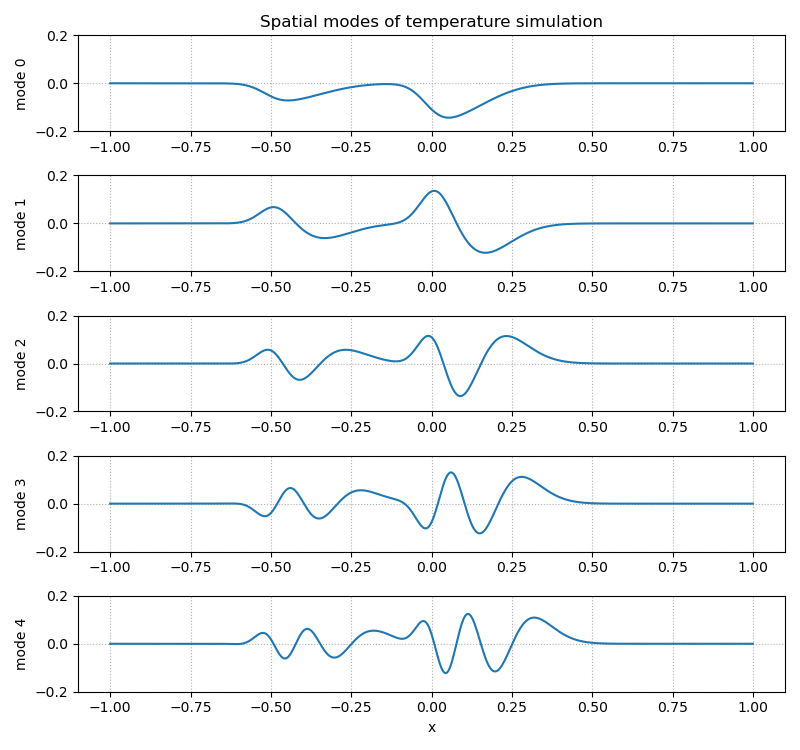

In [9]:
# plot spatial modes
fig, ax = plt.subplots(r, 1, figsize=(8,1.5*r))
ax[0].set_title('Spatial modes of temperature simulation')
for i in range(r):
    ax[i].plot(x, phi[:,i])
    ax[i].set_ylabel(f'mode {i}')
    ax[i].grid(linestyle=':')
    ax[i].set_ylim(-0.2, 0.2)
    
ax[i].set_xlabel('x')
fig.tight_layout()

<IPython.core.display.Javascript object>


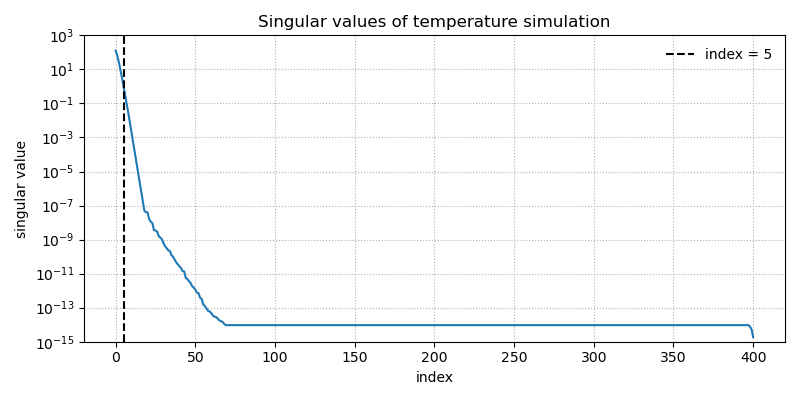

In [10]:
# plot singular values
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(S)
ax.set_title('Singular values of temperature simulation')
ax.set_ylabel('singular value')
ax.set_xlabel('index')
ax.set_yscale('log')
y_min, y_max = 1e-15, 1e3
ax.vlines(5, y_min, y_max, color='k', linestyle='--', label='index = 5')
ax.set_ylim(y_min, y_max)
ax.legend(frameon=False)
ax.grid(linestyle=':')
fig.tight_layout()

In [16]:
# keep track of approximation error
results = []

In [17]:
# interpolation

# select data points
x_interp = np.linspace(-0.8, 0.8, 5)
i_interp = 50 + 100 * np.arange(5)
print(x_interp)
print(x[i_interp,0])
assert np.allclose(x_interp, x[i_interp,0])

# solve exactly determined system
A = phi_interp = phi[i_interp]
b = v_interp = v_true[i_interp]
theta_interp = np.linalg.solve(A, b)
vh_interp = phi @ theta_interp

e_interp = np.linalg.norm(v_true - vh_interp)
results.append(['interpolation', e_interp])
e_interp

[-0.8 -0.4  0.   0.4  0.8]
[-0.8 -0.4  0.   0.4  0.8]


0.17388075558183305

In [18]:
# regression

# select data points
x_regress = np.linspace(-0.8, 0.8, 11)
i_regress = 50 + 40 * np.arange(11)
print(x_regress)
print(x[i_regress,0])
assert np.allclose(x_regress, x[i_regress,0])

# solve overdetermined system
phi_regress = phi[i_regress]
v_regress = v_true[i_regress]
A = phi_regress.T @ phi_regress
b = phi_regress.T @ v_regress
theta_regress = np.linalg.solve(A, b)
vh_regress = phi @ theta_regress

e_regress = np.linalg.norm(v_true - vh_regress)
results.append(['regression', e_regress])
e_regress

[-0.8  -0.64 -0.48 -0.32 -0.16  0.    0.16  0.32  0.48  0.64  0.8 ]
[-0.8  -0.64 -0.48 -0.32 -0.16  0.    0.16  0.32  0.48  0.64  0.8 ]


0.11857507467775377

In [19]:
# Galerkin projection

# use ALL data points

# solve overdetermined system
A = phi.T @ phi
assert np.allclose(A, np.eye(r))

theta_project = phi.T @ v_true
vh_project = phi @ theta_project

e_project = np.linalg.norm(v_true - vh_project)
results.append(['projection', e_project])
e_project

0.05310504241298471

In [20]:
# QDEIM interpolation

# select optimal data points
Q, R, P = scipy.linalg.qr(V.T, pivoting=True)
print_arrays(Q=Q, R=R, P=P)
i_qdeim = P[0:r]
x_qdeim = x[i_qdeim,0]
print(x_qdeim)

# solve exactly determined system
A = phi_qdeim = phi[i_qdeim]
b = v_qdeim = v_true[i_qdeim]
theta_qdeim = np.linalg.solve(A, b)
vh_qdeim = phi @ theta_qdeim

e_qdeim = np.linalg.norm(v_true - vh_qdeim)
results.append(['QDEIM', e_qdeim])
e_qdeim

Q ∈ float64^(401, 401)
R ∈ float64^(401, 501)
P ∈ int32^(501,)
[ 0.036  0.144  0.232 -0.012  0.092]


0.14096579350676453

<IPython.core.display.Javascript object>


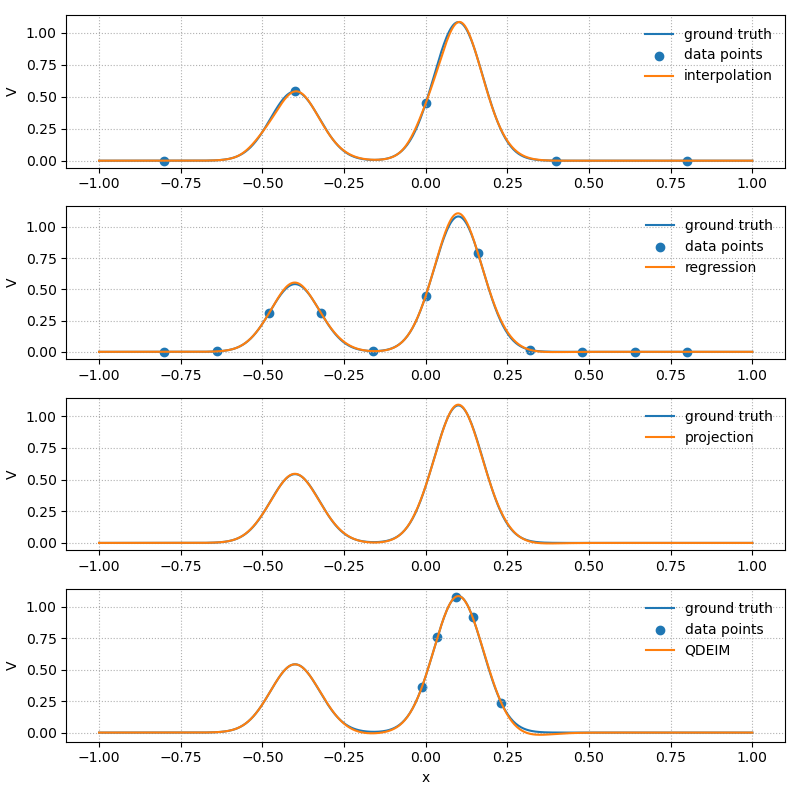

In [31]:
fig, ax = plt.subplots(4, 1, figsize=(8,8))

ax[0].plot(x, v_true, label='ground truth')
ax[0].scatter(x_interp, v_interp, label='data points')
ax[0].plot(x, vh_interp, label='interpolation')

ax[1].plot(x, v_true, label='ground truth')
ax[1].scatter(x_regress, v_regress, label='data points')
ax[1].plot(x, vh_regress, label='regression')

ax[2].plot(x, v_true, label='ground truth')
#ax[2].scatter(x, v_true, label='data points')
ax[2].plot(x, vh_project, label='projection')

ax[3].plot(x, v_true, label='ground truth')
ax[3].scatter(x_qdeim, v_qdeim, label='data points')
ax[3].plot(x, vh_qdeim, label='QDEIM')

for ax_ in ax:
    ax_.legend(frameon=False)
    ax_.grid(linestyle=':')
    ax_.set_ylabel('V')

ax_.set_xlabel('x')

fig.tight_layout()

In [32]:
import pandas as pd
pd.DataFrame(results, columns=['method', 'error']).sort_values('error')

,method,error
2,projection,0.053105
1,regression,0.118575
3,QDEIM,0.140966
0,interpolation,0.173881


From the table and figures above, we see that the best accuracy was achieved by Galerkin projection, which uses all of the available data and reaches an error of 0.053. The second-best method was regression using 11 data points, which reached an error of 11.86. Third place was QDEIM which involves interpolation through 5 data points that were selected using an algorithm for near-optimal placement, and reached an error of 14.1. Last place was interpolation on 5 data points that were chosen naively, and reached an error of 17.39. These results show that we can achieve better generalization error by using more data points, but we can also improve the error for a fixed number of data points by choosing the data points intelligently.